In [96]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

Read data:

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./data/Toys_and_Games.json.gz')
df_meta = getDF('./data/meta_Toys_and_Games.json.gz')

In [3]:
df = df[['reviewText', 'reviewTime', 'overall', 'asin']]
df_meta = df_meta[['price', 'asin']]

Clean data:

In [4]:
df = df.dropna()
df_meta = df_meta.dropna()

In [5]:
df = df[df.reviewTime.str.match(r"\d{2} \d{1,2}, \d{4}")]

In [6]:
df_meta['price'] = df_meta['price'].astype(str)

In [7]:
df_meta = df_meta[df_meta.price.str.match(r"\$\d+\.*\d*")]

In [8]:
df_meta = df_meta[df_meta['price'].str.contains("-")==False]

Transfer data into attributes we want:

In [9]:
df_meta['price'] = df_meta['price'].replace('[\$,]', '', regex=True).astype(float)

In [12]:
# I want to do word count, however, since the row number is too large, my laptop does not support to do so.
df['review_length'] = df['reviewText'].str.len()

In [15]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'],format='%m %d, %Y', errors='coerce')

In [17]:
df['year'] = pd.DatetimeIndex(df['reviewTime']).year

In [19]:
df = df[['review_length', 'year', 'overall', 'asin']]
df_meta = df_meta[['price', 'asin']]

Merge two dataframe:

In [25]:
df_all = pd.merge(df, df_meta, on="asin")

In [27]:
df_all = df_all[['review_length', 'year', 'overall', 'price']]

Start analysis:

In [34]:
df_all.price.describe()

count    5.771791e+06
mean     3.292273e+01
std      9.166946e+01
min      1.000000e-02
25%      9.990000e+00
50%      1.772000e+01
75%      3.295000e+01
max      8.241140e+04
Name: price, dtype: float64

Text(0.5, 0, 'overall rank')

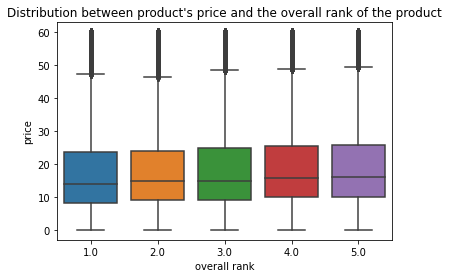

In [45]:
ax = sns.boxplot(x="overall", y="price", data=df_all[df_all['price'] < 60])
ax.set_title("Distribution between product's price and the overall rank of the product")
ax.set_xlabel('overall rank')

From the box plot, we could find the quantiles and median value of price don't change too much with the change in the product's overall rank. Therefore, it seems like there is little correlation between the product's price and the overall rank of the product.

In [47]:
df.review_length.describe()

count    8.194114e+06
mean     1.936981e+02
std      3.096987e+02
min      1.000000e+00
25%      4.100000e+01
50%      1.090000e+02
75%      2.230000e+02
max      3.256300e+04
Name: review_length, dtype: float64

Text(0, 0.5, 'review length')

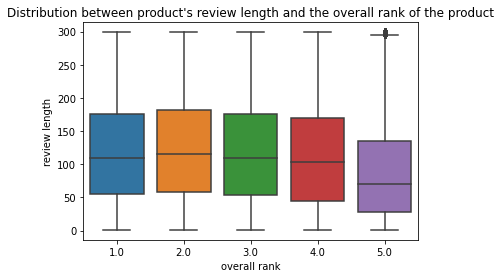

In [50]:
ax = sns.boxplot(x="overall", y="review_length", data=df[df['review_length']<300])
ax.set_title("Distribution between product's review length and the overall rank of the product")
ax.set_xlabel('overall rank')
ax.set_ylabel('review length')

From the box plot, we can find that starting from the overall rank being 2, the median value of review length starts to decrease with the increase of overall rank. The median value and quantiles of review length are the largest when the overall rank is 2. 

Text(0.5, 0, 'year of review')

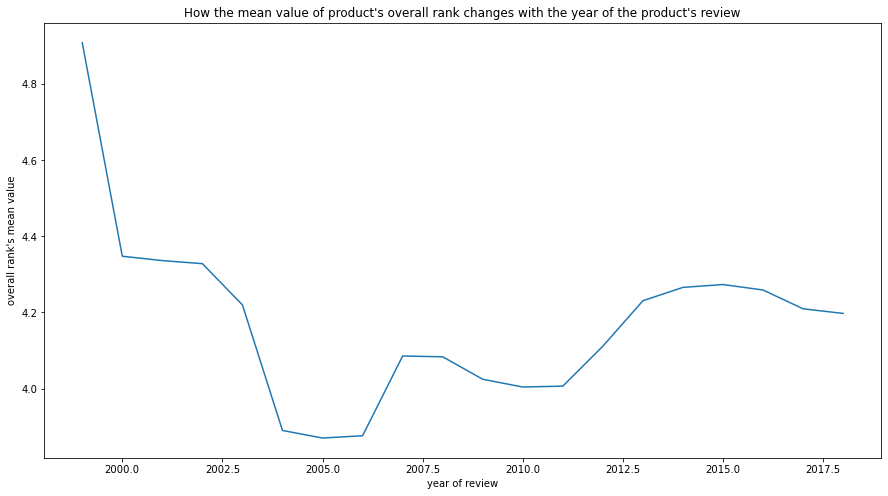

In [70]:
df_year_overall = df.groupby(['year'])['overall'].mean()
df_year_overall = df_year_overall.reset_index()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='year',y='overall',data=df_year_overall)
ax.set_title("How the mean value of product's overall rank changes with the year of the product's review")
ax.set_ylabel("overall rank's mean value")
ax.set_xlabel('year of review')


From the line plot, we could find that the mean value of overall rank decreases from the year 2000 to 2005 and generally increase from 2005 to 2017. The mean value of overall rank is lowest in the year 2005, which is quite interesting. This might be due to the reason that the number of reviews before 2006 is too small, so the data is not that precise.

Linear regression:

We want to find out whether it is possible to predict the overall rank of a product using review length, product's price and the year of the review. The process is the following:

In [75]:
# prepare data for linear regression model
df_all_dummy = pd.get_dummies(df_all, columns=['year'])

In [81]:
# build the linear regression model
X = df_all_dummy[['review_length','price', 'year_1999', 'year_2000',
       'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005',
       'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'year_2018']]
y = df_all_dummy[['overall']]
reg = LinearRegression(fit_intercept = False).fit(X, y)

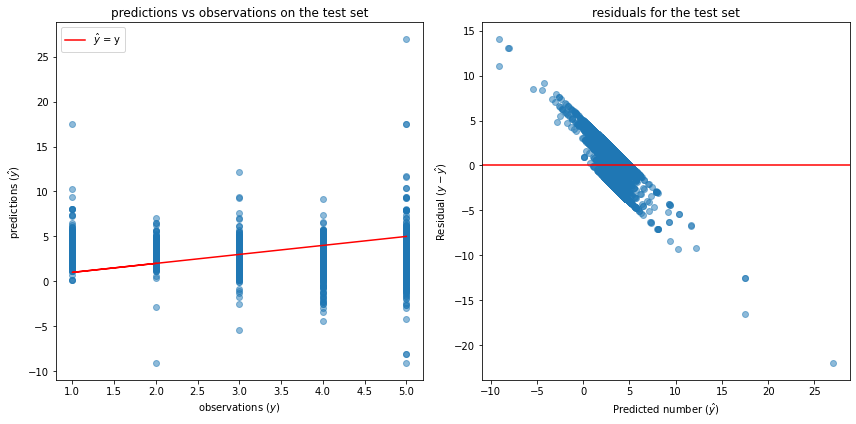

In [100]:
# analyze with plots
y_predict = reg.predict(X)
plt.figure(figsize=(12,6))      # do not change this line

plt.subplot(121)                # do not change this line
# (1) predictions vs observations

plt.scatter(y, y_predict, alpha=0.5)
y_cpy = np.array(y.copy())
y_cpy = y_cpy[(max(y_predict) > y_cpy) &  (min(y_predict) < y_cpy)]
plt.plot(y_cpy, y_cpy, color = 'red', label = '$\hat{y}$ = y')
plt.title('predictions vs observations')
plt.xlabel('observations $(y)$')
plt.ylabel('predictions $(\hat{y})$')
plt.legend()

plt.subplot(122)               # do not change this line
# (2) residual plot
plt.scatter(y_predict, y - y_predict, alpha=0.5)
plt.axhline(y = 0, color='r');
plt.title('residuals plot')
plt.xlabel("Predicted number $(\hat{y})$")
plt.ylabel("Residual $(y - \hat{y})$")

plt.tight_layout()             # do not change this line

From the first plot, we could find that for overall rank < 2.5, most of the points are overestimated(points scattered above the red line), while for overall rank > 3.5, most of the points are underestimated(points scattered below the red line). From the second plot, we could find that there is a clear pattern without a similar vertical spread throughout the entire plot. Hence, the accuracy of the predictions is not reliable.

We alo compute the **Multiple $R^2$** metric:

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

In [99]:
r2 = np.var(predict_y) / np.var(y)
r2

overall    0.01076
dtype: float64

From the multiple $R^2$ metric, we can also find that our linear regression model performs poorly. It only explains 1.076% of the variance in the true y.

Therefore, we need another better model or add more features to predict the product's overall rank.